
# BlocPower data: Buildings in New York City

The four main sections of this notebook are:
1. [Setup](#Setup)
2. [Model energy usage in kWh of buildings](#2.-Model-energy-usage-in-kWh-of-buildings)
3. [Detect buildings that consume energy inefficiently](#3.-Detect-buildings-that-consume-energy-inefficiently)
4. [Export data and models to RStudio](#4.-Export-data-and-models-to-RStudio)


# 1. Setup
## Load data 
+ BlocPower data
+ Public heating and cooling data in NYC

In [2]:
file1 = 'swift://blocpower.spark/BlocPower_T.csv' 
df2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file1).cache()

In [3]:
file2 = 'swift://blocpower.spark/HDD-Features.csv'
dfHDD = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file2).cache()

In [4]:
file3 = 'swift://blocpower.spark/CDD-HDD-Features.csv'
dfCH = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(file3)

## Import Spark and Python Libraries

In [5]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# 2. Model energy usage in kWh of buildings

## Clean and Prepare Data

In [6]:
# define cleaning functions
def energy(v):
    v = v.encode('ascii','ignore').split(' ')[0].replace(',','')
    return np.nan if(v=='') else float(v)
def age(v):
    v = v.encode('ascii','ignore')
    return 2016.0-float(v) if(len(v)==4) else np.nan
def stories(v):
    return float(v)
def sqFeet(v):
    v = v.encode('ascii','ignore').replace(',','')
    return np.nan if(v=='') else float(v) 
def plei(v):
    try:
        vv = float(v)
    except:
        vv = 0.0
    return vv 
# Define udf's 
udfEnergy = udf(energy, DoubleType())
udfAge = udf(age, DoubleType())
udfStories = udf(stories, DoubleType())
udfSqFeet = udf(sqFeet, DoubleType())
udfPlei = udf(plei, DoubleType())

## Apply Data Preparation Functionalities to Dataframe

In [7]:
dfN = df2.withColumn("UTSUM_Electricity_Usage", udfEnergy("UTSUM_Electricity_Usage")) \
         .withColumn("INFO_Year of Construction", udfAge("INFO_Year of Construction")) \
         .withColumn("INFO_Number of Stories", udfStories("INFO_Number of Stories")) \
         .withColumn("INFO_Total Square Feet", udfSqFeet("INFO_Total Square Feet")) \
         .withColumn("PLEI_1_Quantity", udfPlei("PLEI_1_Quantity")) \
         .withColumn("PLEI_3_Quantity", udfPlei("PLEI_3_Quantity")).cache()
dfN = dfN.withColumnRenamed("UTSUM_Electricity_Usage","energy") \
           .withColumnRenamed("INFO_Year of Construction","age") \
           .withColumnRenamed("INFO_Number of Stories","number_stories") \
           .withColumnRenamed("INFO_Total Square Feet","square_feet") \
           .withColumnRenamed("PLEI_1_Quantity","plei_1") \
           .withColumnRenamed("PLEI_3_Quantity","plei_3")            

## Fill in the missing values with an average

In [8]:
# compute mean of energy and age
energy_mean = np.nanmean(np.asarray(dfN.select("energy").rdd.map(lambda r: r[0]).collect()))
age_mean = np.nanmean(np.asarray(dfN.select("age").rdd.map(lambda r: r[0]).collect()))
dfN = dfN.na.fill({"energy": energy_mean, "age": age_mean})

In [9]:
dfOut = dfN.select('energy', 'age', 'number_stories','square_feet','plei_1','plei_3')

## Form a feature matrix and scale the columns

In [10]:
# concatenate 2 data sets
dfNp = dfN.toPandas()
dfHDDp = dfHDD.toPandas()
feat = pd.concat([dfNp, dfHDDp], axis=1)
cols=feat.columns
# scale data 
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler() 
feat = scaler.fit_transform(feat)
dfScaled = pd.DataFrame(feat,columns=cols)

## Explore the correlations

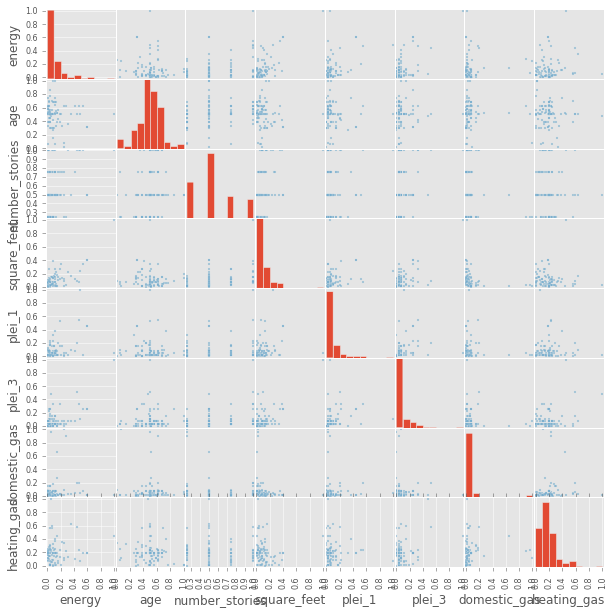

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
ff = pd.tools.plotting.scatter_matrix(dfScaled, diagonal='hist',figsize=(10,10))

## Linear regression model 

Hypothesis: energy usage (kWh) can be explained with building characteristics: 
+ Age of the building 
+ Square feet 
+ Number of stories 
+ Total plugged-in equipment, ...

In [12]:
features = dfScaled.columns.tolist()
response = ['energy']
features.remove(response[0])
# prepare data for regression
from sklearn import linear_model
lr = linear_model.LinearRegression(fit_intercept=True)
y = np.asarray(dfScaled[response]) 
X = dfScaled[features]
# run regression
regr = lr.fit(X,y)
coefs = regr.coef_[0]
# collect regression results
dataRegQ = []
dataRegQ.append(('Intercept', regr.intercept_[0]))
for i in range(len(features)):
    dataRegQ.append((features[i],coefs[i]))
yh = regr.predict(X)
from sklearn.metrics import r2_score
print 'R-Squared: ', r2_score(y,yh)
pd.DataFrame(dataRegQ,columns=['feature_name','coefficient']) #.head()

R-Squared:  0.71750454564


,feature_name,coefficient
0,Intercept,-0.067143
1,age,-0.023500
2,number_stories,0.048774
3,square_feet,0.777122
4,plei_1,0.312308
5,plei_3,0.122954
6,domestic_gas,0.229171
7,heating_gas,0.143661


## Visualize the model accuracy

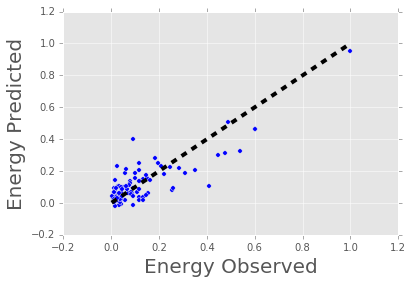

In [13]:
fig, ax = plt.subplots()
ax.scatter(y, yh)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Energy Observed',fontsize=20)
ax.set_ylabel('Energy Predicted',fontsize=20)
plt.show()

# 3. Detect buildings that consume energy inefficiently

## Engineered characteristics of heating and cooling systems for the buildings

In [14]:
dfCH = dfCH.toPandas()
dfR = dfCH[['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']]
dfN = dfR/dfR.max()
dfCH_n = pd.concat((dfN, dfCH['Property Name']),1)

## Identify the buildings that consume energy inefficiently
+ Air conditioner
+ Plugged-in equipment (microwaves, computers, refrigerators, ...)
+ Gas for domestic usage
+ Gas for heating

For example, the following buildings consume AC inefficiently:

In [15]:
cname = 'ac_consumption' #'heating_gas'
dfCH_n[dfCH_n[cname]>dfCH_n.quantile(0.95)[0]][['Property Name',cname]]

,Property Name,ac_consumption
84,CAAABagels,0.997882
86,PaninicoCafeReport,1.000000
87,Curran'sSuperiorMeatsReport,0.717030


## Many dimensions are used to measure energy inefficiencies
Here we are using four inefficiency metrics associated with: 
+ Plugged-in equipment
+ Air conditioning
+ Domestic gas 
+ Heating gas 

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(dfN)
featReduced = pca.fit_transform(dfN)
kmeans = KMeans(n_clusters=4, tol=0.00001, random_state=1)
kmeans.fit(featReduced)
labels = kmeans.predict(featReduced)
buildings = np.asarray(dfCH['Property Name'].values.tolist())

## Can we train a model to consider all of the dimesions to detect inefficient buildings?

Yes. K-means clustering helps us identify groups of buildings that consume energy inefficiently.

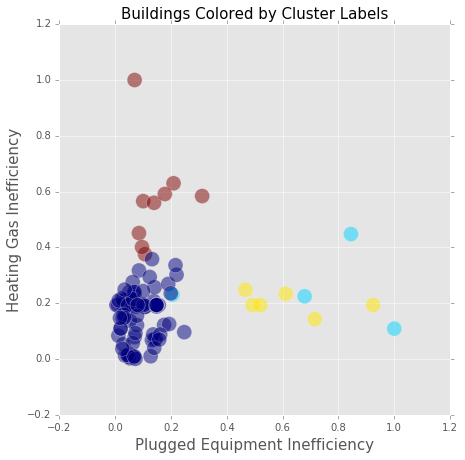

In [17]:
# inefficiency dimensions: ['plug_load_consumption','ac_consumption','domestic_gas','heating_gas']
x = dfCH_n['plug_load_consumption'] 
y = dfCH_n['heating_gas'] 
plt.scatter(x, y, s=225, c=labels, alpha=0.5)
plt.gcf().set_size_inches( (7, 7) )
plt.xlabel('Plugged Equipment Inefficiency',fontsize=15)
plt.ylabel('Heating Gas Inefficiency',fontsize=15)
tt = 'Buildings Colored by Cluster Labels' 
plt.title(tt,fontsize=15)
plt.show()

## The clustering model helps us identify inefficient groups of buildings 

+ Note that in the above figure, most buildings are part of the purple cluster.
+ Buildings that are part of the brown, yellow, and blue clusters are more inefficient than the ones that are part of the purple cluster.
+ Labels are re-coded into a binary variable where 1 is inefficient (brown, yellow or blue clusters) and 0 otherwise (purple cluster).

In [18]:
# binary variable to identify inefficient buildings
label_binary = []
for v in labels:
    label_binary.append(0 if (v == 0) else 1)
label_binary = np.asarray(label_binary)

## Classification model to identify the inefficient buildings

In [19]:
# train classifier
log = linear_model.LogisticRegression(tol = 0.00001, max_iter = 100)
log.fit(featReduced, label_binary)
accuracy = log.score(featReduced, label_binary)
y_pred = log.predict(featReduced)
print "Model Accuracy: ", accuracy

Model Accuracy:  0.893203883495


In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['efficient','inefficient'], rotation=0)
    plt.yticks(tick_marks, ['efficient','inefficient'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[84  0]
 [11  8]]


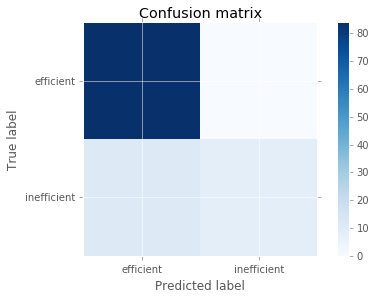

In [21]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(label_binary, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

Normalized confusion matrix
[[ 1.    0.  ]
 [ 0.58  0.42]]


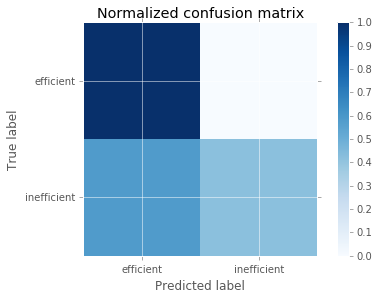

In [22]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

# 4. Export data and models to RStudio
We built a 
_[Shiny app](https://ibmdatascience.shinyapps.io/SparkSummitDemo/)_ that summarizes our insights.

In [24]:
fileNameOut = 'swift://blocpower.spark/export_data.csv'
dfOut.write.format('com.databricks.spark.csv').options(header='true').save(fileNameOut)